In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torchvision
from safetensors.torch import load_model, save_model

from data.get_data import get_cifar10
import core.utils as U
from core.device import get_device
from core.networks.resnet import ResNet
from core.optimizers.sgd_lrd import SGD_LRD
from core.scheduler import CosineAnnealingWarmupRestarts

In [2]:
model_path = "./models"
result_path = "./results"
batch_size = 128
layers = 32
n = int((layers - 2) / 6)
epochs = 200
learning_rate = 0.1
optimizer_name = "SGD_LRD"
activation_fn_name = "CELU"

device = get_device()

loss_history = []
accuracy_history = []

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

train_loader, test_loader = get_cifar10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
dateiter = iter(train_loader)
images, labels = next(dateiter)

max_img_grid = 8 if batch_size > 8 else batch_size

images = images[:max_img_grid]
labels = labels[:max_img_grid]

U.show_normalized_img(torchvision.utils.make_grid(images))

print(", ".join(f"{classes[labels[j]]:5s}" for j in range(max_img_grid)))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\thinl\scoop\apps\miniconda3\current\envs\torch\Lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\thinl\scoop\apps\miniconda3\current\envs\torch\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\thinl\scoop\apps\miniconda3\current\envs\torch\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\thinl\scoop\apps\miniconda3\current\envs\torch\Lib\site-packages\torchvision\datasets\cifar.py", line 118, in __getitem__
    img = self.transform(img)
          ^^^^^^^^^^^^^^^^^^^
TypeError: 'list' object is not callable


In [4]:
import torch
network = ResNet(n)
use_pretrained_model = False

model_name = f"ResNet{layers}-CIFAR10-{activation_fn_name}-{optimizer_name}-{learning_rate}"

try:
    load_model(network, f"{model_path}/{model_name}.safetensors")
    use_pretrained_model = True
    print("Loaded pretrained model")
except:
    network = nn.DataParallel(network)
    print("No pretrained model found")

network.to(device)

print("Model loaded")

No pretrained model found
Model loaded


In [5]:
optimizers = {
    "sgd": opt.SGD(network.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4),
    "adamw": opt.AdamW(network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4, amsgrad=False),
    "sgd_lrd": SGD_LRD(network.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4, dropout=0.5),
}

criterion = nn.CrossEntropyLoss()
optimizer = optimizers[optimizer_name.lower()]
scheduler = CosineAnnealingWarmupRestarts(optimizer, epochs/2, max_lr=learning_rate, min_lr=learning_rate/100, warmup_steps=4)

In [6]:
if not use_pretrained_model:
    for epoch in range(epochs):
        train_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            _, predicted = outputs.max(1)
            total +=  labels.size(0)
            correct += predicted.eq(labels).sum().item()

                
        train_accuracy = correct / total * 100
        accuracy_history.append(train_accuracy)
        loss_history.append(loss.cpu().item())
        
        print(f"epoch {epoch + 1} loss: {loss:.3f}, acc: {train_accuracy:.3f}%")

        scheduler.step()
                
    save_model(network, f"{model_path}/{model_name}.safetensors")

    with open(f"{result_path}/{model_name}.txt", "w", encoding="utf-8") as f:
        a = {
            "loss": loss_history,
            "acc": accuracy_history
        }
        f.write(json.dumps(a))

    print("Train finished")
else:
    with open(f"{result_path}/{model_name}.txt", "r", encoding="utf-8") as f:
        json_file = json.load(f)
        loss_history = json_file["loss"]
        accuracy_history = json_file["acc"]

epoch 1 loss: 1.834, acc: 28.178%
epoch 2 loss: 1.415, acc: 42.780%
epoch 3 loss: 1.039, acc: 56.164%
epoch 4 loss: 0.940, acc: 63.954%
epoch 5 loss: 0.766, acc: 69.670%
epoch 6 loss: 1.159, acc: 73.608%
epoch 7 loss: 0.638, acc: 75.642%
epoch 8 loss: 0.573, acc: 76.958%
epoch 9 loss: 0.841, acc: 78.296%
epoch 10 loss: 0.620, acc: 79.128%
epoch 11 loss: 0.763, acc: 79.526%
epoch 12 loss: 0.787, acc: 80.228%
epoch 13 loss: 0.645, acc: 80.696%
epoch 14 loss: 0.507, acc: 81.116%
epoch 15 loss: 0.591, acc: 81.376%
epoch 16 loss: 0.518, acc: 81.596%
epoch 17 loss: 0.286, acc: 81.704%
epoch 18 loss: 0.422, acc: 82.230%
epoch 19 loss: 0.456, acc: 82.432%
epoch 20 loss: 0.649, acc: 82.688%
epoch 21 loss: 0.692, acc: 82.798%
epoch 22 loss: 0.401, acc: 83.130%
epoch 23 loss: 0.420, acc: 83.380%
epoch 24 loss: 0.325, acc: 83.294%
epoch 25 loss: 0.494, acc: 83.730%
epoch 26 loss: 0.504, acc: 83.548%
epoch 27 loss: 0.356, acc: 84.100%
epoch 28 loss: 0.457, acc: 84.096%
epoch 29 loss: 0.289, acc: 84

Min train loss: 0.053893864254951476


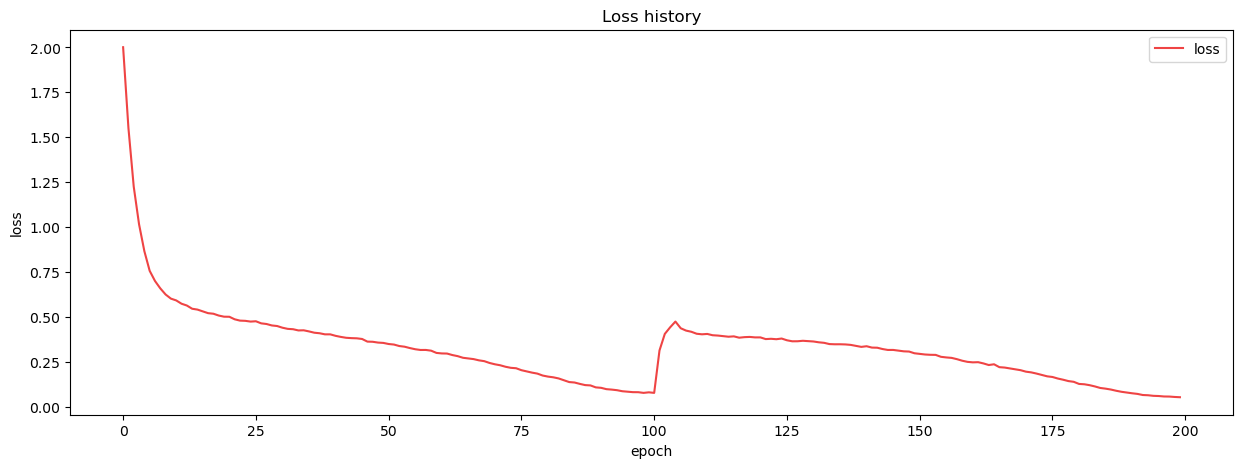

In [13]:
X = np.arange(epochs)

print(f"Min train loss: {np.min(loss_history)}")
fig = plt.gcf()
plt.plot(X, loss_history, color=U.get_color(0), label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss history")
fig.set_size_inches(15, 5)
plt.show()

Max train accuracy: 0.9847


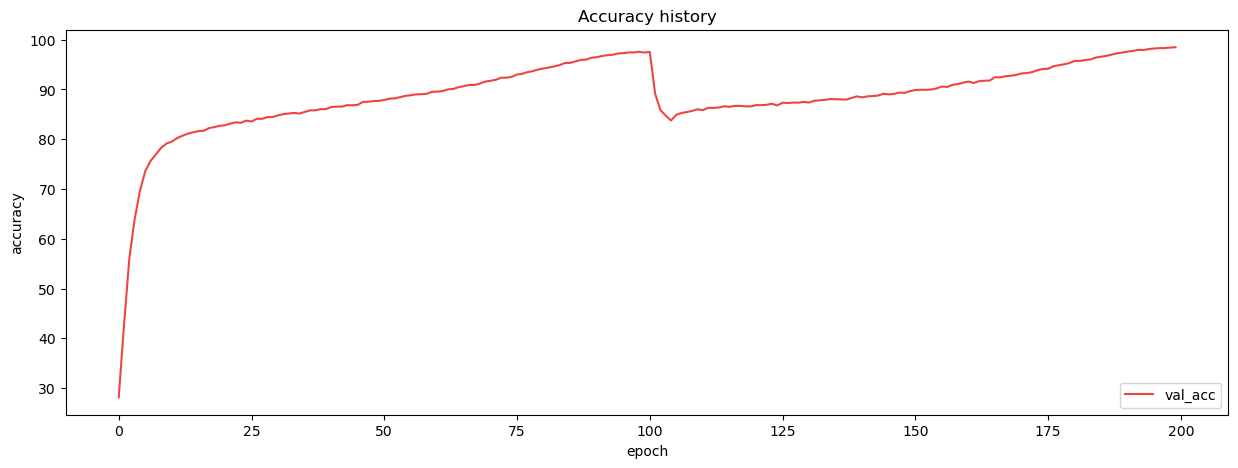

In [8]:
print(f"Max train accuracy: {np.max(accuracy_history) / 100}")
fig = plt.gcf()
plt.plot(X, accuracy_history, color=U.get_color(0), label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy history")
fig.set_size_inches(15, 5)
plt.show()

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = network(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
print(f"Accuracy of 10,000 test images: {100 * correct // total}%")

Accuracy of 10,000 test images: 89%


In [10]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = network(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                
            total_pred[classes[label]] += 1
            
for classname, corrent_count in correct_pred.items():
    train_accuracy = 100 * float(corrent_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {train_accuracy:.1f}%")

Accuracy for class: plane is 90.6%
Accuracy for class: car   is 95.6%
Accuracy for class: bird  is 86.3%
Accuracy for class: cat   is 78.8%
Accuracy for class: deer  is 90.5%
Accuracy for class: dog   is 84.5%
Accuracy for class: frog  is 91.7%
Accuracy for class: horse is 92.5%
Accuracy for class: ship  is 93.9%
Accuracy for class: truck is 93.8%
